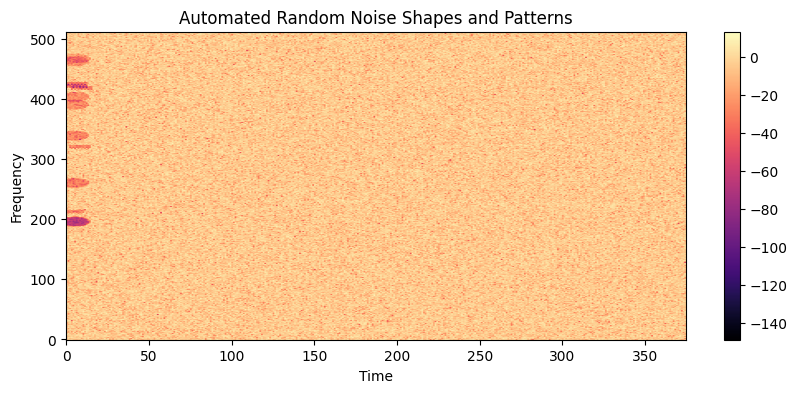

In [8]:
# 단계별 구현 계획
# 1. SpectrogramModifier 클래스 구현
#    - 오디오 신호로부터 스펙트로그램 계산 (STFT, dB 변환)
#    - 노이즈 마스크 적용 메서드 구현
#    - 스펙트로그램 시각화 메서드 구현
#
# 2. DistributionEngine 구현
#    - "normal", "uniform", "none" 등의 분포 타입 관리
#    - create(type, **params) 메서드를 통해 적절한 분포 함수 객체 반환
#
# 3. Shape 클래스 계층 구현
#    - Circle, HorizontalStripe 등 Shape 클래스들
#    - 각 Shape는 스펙트로그램 상에 특정 위치, 크기, 회전, 기울기(gradient), 파워분포를 사용하여 노이즈 마스크 생성
#
# 4. Pattern 클래스 계층 구현
#    - random_shape_on_range 등 패턴별 클래스를 구현
#    - 패턴은 내부적으로 Shape 객체를 여러 개 생성하고 스펙트로그램에 적용
#
# 5. ShapeFactory, PatternFactory 구현
#    - 문자열로 shape나 pattern을 요청하면 해당 클래스 인스턴스를 반환
#
# 6. ParameterValidator 구현
#    - 매개변수 검증
#
# 7. NoisePipeline 구현
#    - shape_factory, pattern_factory, distribution_engine, spectro_modifier를 속성으로 가짐
#    - add_shape(shape), add_pattern(pattern) 메서드를 통해 Shape나 Pattern 추가
#    - generate(signal)로 최종 노이즈가 적용된 스펙트로그램 생성
#    - add_random_shape(), add_random_pattern() 메서드를 구현해 자동으로 임의 파라미터를 가진 노이즈 요소 추가
#
# 8. 실제 코드 예제
#    - SpectrogramModifier, NoisePipeline, Factory, DistributionEngine 등 구현 후
#      signal에 랜덤 shape와 pattern 추가
#    - 최종 스펙트로그램 출력

import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

class SpectrogramModifier:
    def __init__(self, sample_rate, n_fft, hop_length, noise_strength, noise_type, noise_params):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.noise_strength = noise_strength
        self.noise_type = noise_type
        self.noise_params = noise_params
        self.spectrogram = None
        
    def compute_spectrogram(self, signal):
        # 간단한 예제: STFT 후 dB 변환
        # 실제 구현 시 librosa.stft 등을 사용할 수 있음
        # 여기서는 더미 스펙트로그램 생성
        spec = np.abs(np.random.randn(self.n_fft//2+1, len(signal)//self.hop_length))
        self.spectrogram = 20 * np.log10(spec + 1e-6)
        return self.spectrogram

    def apply_mask(self, mask):
        if self.spectrogram is not None:
            self.spectrogram += mask

    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram'):
        fig, ax = plt.subplots(figsize=(10, 4))
        img = ax.imshow(self.spectrogram, aspect='auto', origin='lower', cmap=colormap)
        if show_labels:
            ax.set_xlabel('Time')
            ax.set_ylabel('Frequency')
        ax.set_title(title)
        plt.colorbar(img, ax=ax)
        return fig, ax


class Distribution(ABC):
    @abstractmethod
    def sample(self, shape):
        pass

class NormalDistribution(Distribution):
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def sample(self, shape):
        return np.random.normal(self.mean, self.stddev, shape)

class UniformDistribution(Distribution):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def sample(self, shape):
        return np.random.uniform(self.min_val, self.max_val, shape)

class NoneDistribution(Distribution):
    def sample(self, shape):
        return np.zeros(shape)

class DistributionEngine:
    def create(self, dist_type, **params):
        if dist_type == "normal":
            return NormalDistribution(params.get('mean', 0), params.get('stddev', 1))
        elif dist_type == "uniform":
            return UniformDistribution(params.get('min', -1), params.get('max', 1))
        else:
            return NoneDistribution()

class Shape(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape):
        pass

class CircleShape(Shape):
    def __init__(self, position, size, rotation, gradient_time, gradient_freq, power_distribution):
        self.position = position
        self.size = size
        self.rotation = rotation
        self.gradient_time = gradient_time
        self.gradient_freq = gradient_freq
        self.power_distribution = power_distribution

    def create_mask(self, spectro_shape):
        mask = np.zeros(spectro_shape)
        center_t, center_f = self.position
        radius_t, radius_f = self.size
        t_indices = np.arange(spectro_shape[1])
        f_indices = np.arange(spectro_shape[0])
        tt, ff = np.meshgrid(t_indices, f_indices)
        dist = ((tt - center_t)**2 / (radius_t**2) + (ff - center_f)**2 / (radius_f**2))
        circle_mask = (dist <= 1).astype(float)
        noise = self.power_distribution.sample(circle_mask.shape)
        mask = circle_mask * noise
        # 기울기 적용 (예시: 시간축으로 gradient_time 만큼 증가)
        # 실제 구현 시 더 정교한 적용 가능
        mask *= (1 + self.gradient_time*(tt/tt.max()))*(1 + self.gradient_freq*(ff/ff.max()))
        return mask

class HorizontalStripeShape(Shape):
    def __init__(self, position, size, rotation, gradient_time, gradient_freq, is_dot_line, power_distribution):
        self.position = position
        self.size = size
        self.rotation = rotation
        self.gradient_time = gradient_time
        self.gradient_freq = gradient_freq
        self.is_dot_line = is_dot_line
        self.power_distribution = power_distribution

    def create_mask(self, spectro_shape):
        mask = np.zeros(spectro_shape)
        center_t, center_f = self.position
        size_t, size_f = self.size
        t_indices = np.arange(spectro_shape[1])
        f_indices = np.arange(spectro_shape[0])
        tt, ff = np.meshgrid(t_indices, f_indices)
        stripe_mask = ((ff >= (center_f - size_f/2)) & (ff <= (center_f + size_f/2)) & 
                       (tt >= (center_t - size_t/2)) & (tt <= (center_t + size_t/2)))
        stripe_mask = stripe_mask.astype(float)

        if self.is_dot_line:
            dot_pattern = ((tt.astype(int) + ff.astype(int)) % 2 == 0).astype(float)
            stripe_mask *= dot_pattern

        noise = self.power_distribution.sample(stripe_mask.shape)
        mask = stripe_mask * noise
        mask *= (1 + self.gradient_time*(tt/tt.max()))*(1 + self.gradient_freq*(ff/ff.max()))
        return mask

class ShapeFactory:
    def create(self, shape_name, **kwargs):
        if shape_name == "circle":
            return CircleShape(
                position=kwargs.get('position', (0, 0)),
                size=kwargs.get('size', (10, 10)),
                rotation=kwargs.get('rotation', 0),
                gradient_time=kwargs.get('gradient_time', 0),
                gradient_freq=kwargs.get('gradient_freq', 0),
                power_distribution=kwargs.get('power_distribution', NoneDistribution())
            )
        elif shape_name == "horizontal_stripe":
            return HorizontalStripeShape(
                position=kwargs.get('position', (0, 0)),
                size=kwargs.get('size', (10, 1)),
                rotation=kwargs.get('rotation', 0),
                gradient_time=kwargs.get('gradient_time', 0),
                gradient_freq=kwargs.get('gradient_freq', 0),
                is_dot_line=kwargs.get('is_dot_line', False),
                power_distribution=kwargs.get('power_distribution', NoneDistribution())
            )
        else:
            return None

class Pattern(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, shape_factory, distribution_engine):
        pass

class RandomShapeOnRangePattern(Pattern):
    def __init__(self, params):
        self.params = params

    def create_mask(self, spectro_shape, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        n = self.params.get('n', 10)
        time_start = self.params.get('time_start', 0)
        time_end = self.params.get('time_end', spectro_shape[1])
        freq_start = self.params.get('freq_start', 0)
        freq_end = self.params.get('freq_end', spectro_shape[0])
        shape_name = self.params.get('shape', 'circle')
        shape_params = self.params.get('parameters', {})

        for _ in range(n):
            t = np.random.uniform(time_start, time_end)
            f = np.random.uniform(freq_start, freq_end)
            shape_params_local = shape_params.copy()
            pd_params = shape_params_local.get('power_distribution', {})
            dist_type = pd_params.get('type', 'normal')
            dist = distribution_engine.create(dist_type, **pd_params)
            shape_params_local['power_distribution'] = dist
            shape_params_local['position'] = (t, f)
            shape_obj = shape_factory.create(shape_name, **shape_params_local)
            shape_mask = shape_obj.create_mask(spectro_shape)
            mask += shape_mask
        return mask

class PatternFactory:
    def create(self, pattern_name, params):
        if pattern_name == "random_shape_on_range":
            return RandomShapeOnRangePattern(params)
        else:
            return None

class NoisePipeline:
    def __init__(self, spectro_mod):
        self.spectro_mod = spectro_mod
        self.shape_factory = ShapeFactory()
        self.pattern_factory = PatternFactory()
        self.distribution_engine = DistributionEngine()
        self.shapes = []
        self.patterns = []

    def add_shape(self, shape):
        self.shapes.append(shape)
        return self

    def add_pattern(self, pattern):
        self.patterns.append(pattern)
        return self

    def generate(self, signal):
        spec = self.spectro_mod.compute_spectrogram(signal)
        total_mask = np.zeros_like(spec)
        for shape in self.shapes:
            shape_mask = shape.create_mask(spec.shape)
            total_mask += shape_mask
        for pattern in self.patterns:
            pattern_mask = pattern.create_mask(spec.shape, self.shape_factory, self.distribution_engine)
            total_mask += pattern_mask
        self.spectro_mod.apply_mask(total_mask)
        return self.spectro_mod.spectrogram

    def add_random_shape(self):
        shape_type = np.random.choice(['circle', 'horizontal_stripe'])
        if shape_type == 'circle':
            dist = self.distribution_engine.create("normal",
                                                   mean=np.random.uniform(-50, -30),
                                                   stddev=np.random.uniform(1, 5))
            shape = self.shape_factory.create(
                "circle",
                position=(np.random.uniform(0, self.spectro_mod.n_fft),
                          np.random.uniform(0, self.spectro_mod.sample_rate/2)),
                size=(np.random.uniform(5, 15), np.random.uniform(5, 15)),
                rotation=np.random.uniform(0, 360),
                gradient_time=np.random.uniform(-1, 1),
                gradient_freq=np.random.uniform(-1, 1),
                power_distribution=dist
            )
        else:
            dist = self.distribution_engine.create("uniform",
                                                   min=np.random.uniform(-60, -40),
                                                   max=np.random.uniform(-20, 0))
            shape = self.shape_factory.create(
                "horizontal_stripe",
                position=(np.random.uniform(0, self.spectro_mod.n_fft),
                          np.random.uniform(0, self.spectro_mod.sample_rate/2)),
                size=(np.random.uniform(10, 50), np.random.uniform(5, 15)),
                rotation=0,
                gradient_time=np.random.uniform(-1, 1),
                gradient_freq=np.random.uniform(-1, 1),
                is_dot_line=np.random.choice([True, False]),
                power_distribution=dist
            )
        self.add_shape(shape)
        return self

    def add_random_pattern(self):
        pattern_type = np.random.choice(['random_shape_on_range'])
        if pattern_type == 'random_shape_on_range':
            params = {
                "n": np.random.randint(5, 15),
                "time_start": np.random.uniform(0, 5),
                "time_end": np.random.uniform(5, 10),
                "freq_start": np.random.uniform(0, 400),
                "freq_end": np.random.uniform(400, 800),
                "position_distribution": np.random.choice(['uniform', 'normal']),
                "gradient_time": np.random.uniform(-1, 1),
                "gradient_freq": np.random.uniform(-1, 1),
                "shape": np.random.choice(['circle', 'horizontal_stripe']),
                "parameters": {
                    "power_distribution": {
                        "type": "normal",
                        "mean": np.random.uniform(-50, -30),
                        "stddev": np.random.uniform(1, 5)
                    },
                    "size": (np.random.uniform(5, 15), np.random.uniform(5, 15)),
                    "rotation": np.random.uniform(0, 360),
                    "gradient_time": np.random.uniform(-1, 1),
                    "gradient_freq": np.random.uniform(-1, 1),
                    "is_dot_line": np.random.choice([True, False])
                }
            }
            pattern = self.pattern_factory.create("random_shape_on_range", params)
            self.add_pattern(pattern)
        return self

# 예제 사용
sample_rate = 16000
duration = 12
n_samples = sample_rate * duration
np.random.seed(42)
signal = np.random.normal(-80, 1, n_samples)

spectro_mod = SpectrogramModifier(
    sample_rate=sample_rate,
    n_fft=1024,
    hop_length=512,
    noise_strength=600,
    noise_type='gaussian',
    noise_params={'mean': -80, 'std': 1}
)

pipeline = NoisePipeline(spectro_mod)

num_random_shapes = 5
num_random_patterns = 2

for _ in range(num_random_shapes):
    pipeline.add_random_shape()

for _ in range(num_random_patterns):
    pipeline.add_random_pattern()

result_spectrogram = pipeline.generate(signal)
fig, ax = spectro_mod.plot_spectrogram(
    show_labels=True,
    colormap='magma',
    title='Automated Random Noise Shapes and Patterns'
)
plt.show()


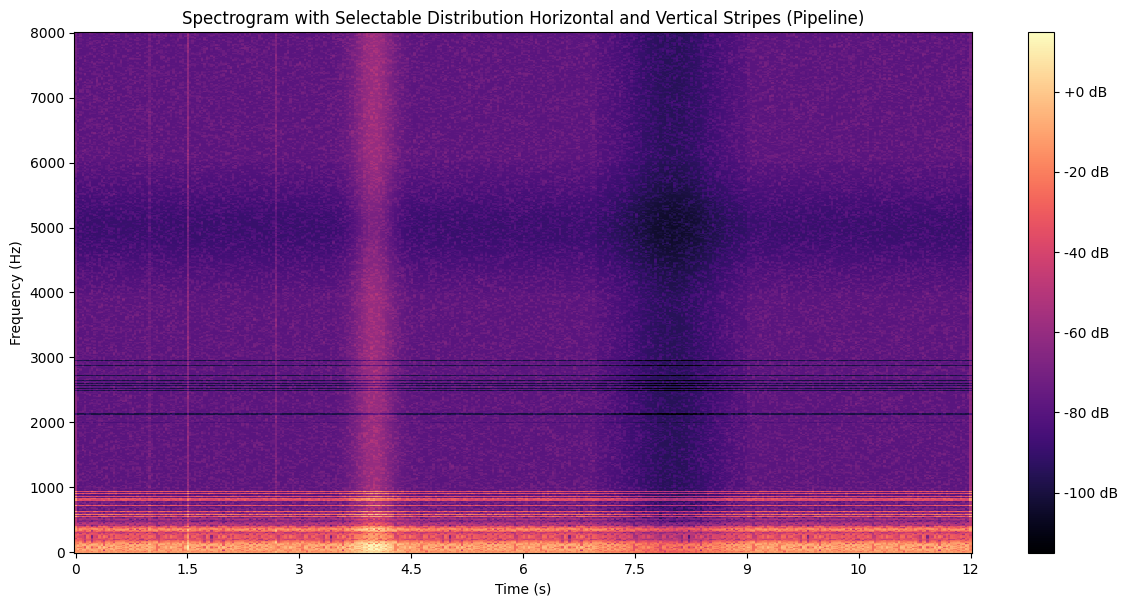

In [8]:
# 요구사항:
# - 기존 SpectrogramModifier와 NoisePipeline 구조를 유지하면서,
#   Horizontal/Vertical Stripe, 주파수 및 시간 구간 분포 기반 dB 패턴 추가 등을
#   Shape 또는 Pattern 형태로 파이프라인에 통합
# - 기존 JSON/YAML 등 외부 설정파일 없이 코드 상에서 유연하게 구성
# - PEP8 스타일 준수
# - 한글 주석

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from abc import ABC, abstractmethod


class SpectrogramModifier:
    def __init__(self, sample_rate=16000, n_fft=1024, hop_length=512,
                 noise_strength=0.1, noise_type='gaussian', noise_params=None):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.noise_strength = noise_strength
        self.noise_type = noise_type
        self.noise_params = noise_params if noise_params else {}
        self.signal = None
        self.signal_with_noise = None
        self.S_db = None

    def _generate_gaussian_noise(self, length, params):
        mean = params.get('mean', 0.0)
        std = params.get('std', 1.0)
        return np.random.normal(mean, std, length)

    def _generate_uniform_noise(self, length, params):
        low = params.get('low', -1.0)
        high = params.get('high', 1.0)
        return np.random.uniform(low, high, length)

    def _generate_perlin_noise(self, length, params):
        # Perlin 노이즈 생성 (간단화 버전)
        def fade(t):
            return 6*t**5 - 15*t**4 + 10*t**3

        seed = params.get('seed', 42)
        np.random.seed(seed)
        perm = np.arange(256)
        np.random.shuffle(perm)
        perm = np.stack([perm, perm]).flatten()
        scale = params.get('scale', 50.0)
        xs = np.linspace(0, length/scale, length)
        xi = np.floor(xs).astype(int)
        xf = xs - xi
        xi = xi % 256
        left_hash = perm[xi]
        right_hash = perm[xi+1]
        u = fade(xf)
        left_grad = ((left_hash & 1)*2-1)*xf
        right_grad = ((right_hash & 1)*2-1)*(xf-1)
        noise = (1-u)*left_grad + u*right_grad
        noise = noise / np.max(np.abs(noise))
        return noise

    def generate_noise(self, signal):
        length = len(signal)
        nt = self.noise_type
        p = self.noise_params
        if nt == 'gaussian':
            noise = self._generate_gaussian_noise(length, p)
        elif nt == 'uniform':
            noise = self._generate_uniform_noise(length, p)
        elif nt == 'perlin':
            noise = self._generate_perlin_noise(length, p)
        else:
            noise = np.zeros_like(signal)
        return signal + noise * self.noise_strength

    def compute_spectrogram(self, signal):
        self.signal = signal
        self.signal_with_noise = self.generate_noise(signal)
        S = np.abs(librosa.stft(
            self.signal_with_noise, n_fft=self.n_fft, hop_length=self.hop_length, window='hann'))
        self.S_db = librosa.amplitude_to_db(S, ref=np.max)
        return self.S_db

    def _get_freqs(self):
        return np.linspace(0, self.sample_rate / 2, self.S_db.shape[0])

    def _get_times(self):
        return librosa.frames_to_time(np.arange(self.S_db.shape[1]),
                                      sr=self.sample_rate,
                                      hop_length=self.hop_length)

    def apply_dB_mask(self, dB_mask):
        # dB_mask 크기: self.S_db.shape
        self.S_db += dB_mask


    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram'):
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        fig, ax = plt.subplots(figsize=(12, 6))
        img = librosa.display.specshow(
            self.S_db,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap=colormap
        )
        if show_labels:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(title)
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0.5)
        return fig, ax


class Distribution(ABC):
    @abstractmethod
    def sample(self, shape):
        pass

class NormalDistribution(Distribution):
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def sample(self, shape):
        return np.random.normal(self.mean, self.stddev, shape)

class UniformDistribution(Distribution):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def sample(self, shape):
        return np.random.uniform(self.min_val, self.max_val, shape)

class NoneDistribution(Distribution):
    def sample(self, shape):
        return np.zeros(shape)

class DistributionEngine:
    def create(self, dist_type, **params):
        if dist_type == "normal":
            return NormalDistribution(params.get('mean', 0), params.get('stddev', 1))
        elif dist_type == "uniform":
            return UniformDistribution(params.get('min', -1), params.get('max', 1))
        else:
            return NoneDistribution()


# 여기서부터는 dB 스펙트로그램 상에 선형(수평/수직선), 구간 분포를 적용하는 Shape 구현
# 이 Shape들은 spectrogram의 dB값에 추가할 마스크를 생성
# 각 Shape는 create_mask(spectro_shape, spectro_mod) 메서드를 구현
# spectro_mod를 받아서 freqs, times를 활용

class DBShape(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod):
        pass

class HorizontalStripeDBShape(DBShape):
    # 특정 주파수 지점에 dB 값 추가
    def __init__(self, freq, strength_dB):
        self.freq = freq
        self.strength_dB = strength_dB

    def create_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_idx = np.argmin(np.abs(freqs - self.freq))
        mask[freq_idx, :] += self.strength_dB
        return mask

class HorizontalRangeDistributionDBShape(DBShape):
    # 주파수 구간에 대해 분포 기반 dB 값 추가
    def __init__(self, freq_min, freq_max, strength_dB, distribution='gaussian', distribution_params=None):
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.strength_dB = strength_dB
        self.distribution = distribution
        self.distribution_params = distribution_params if distribution_params else {}

    def _get_distribution(self, values, distribution, params):
        if distribution == 'gaussian':
            sigma = params.get('sigma', 5)
            center = (values.min() + values.max()) / 2
            dist = np.exp(-0.5 * ((values - center) / sigma)**2)
        else:
            # 기본 gaussian 사용
            sigma = params.get('sigma', 5)
            center = (values.min() + values.max()) / 2
            dist = np.exp(-0.5 * ((values - center) / sigma)**2)
        dist /= dist.max()
        return dist

    def create_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        if len(freq_indices) == 0:
            return mask
        dist_values = freqs[freq_indices]
        energy_distribution = self._get_distribution(dist_values, self.distribution, self.distribution_params)
        # freq_indices 범위에 strength_dB * distribution 적용
        # 모든 시간축에 동일 적용
        for i, fi in enumerate(freq_indices):
            mask[fi, :] += self.strength_dB * energy_distribution[i]
        return mask

class RandomHorizontalStripesDBShape(DBShape):
    # 주파수 구간 내 n개 랜덤 주파수 지점에 dB 추가
    def __init__(self, freq_min, freq_max, strength_dB, n, mode='random'):
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.strength_dB = strength_dB
        self.n = n
        self.mode = mode

    def create_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        available_freqs = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        if len(available_freqs) == 0:
            return mask
        if self.mode == 'linear':
            selected_indices = np.linspace(available_freqs.min(), available_freqs.max(),
                                           num=self.n, dtype=int)
            selected_indices = selected_indices[selected_indices < len(freqs)]
        else:
            n_sel = min(self.n, len(available_freqs))
            selected_indices = np.random.choice(available_freqs, size=n_sel, replace=False)
        for fi in selected_indices:
            mask[fi, :] += self.strength_dB
        return mask

class VerticalStripeDBShape(DBShape):
    # 특정 시간 지점에 dB 값 추가
    def __init__(self, time, strength_dB):
        self.time = time
        self.strength_dB = strength_dB

    def create_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        time_idx = np.argmin(np.abs(times - self.time))
        mask[:, time_idx] += self.strength_dB
        return mask

class VerticalRangeDistributionDBShape(DBShape):
    # 시간 구간에 분포 기반 dB 값 추가
    def __init__(self, time_min, time_max, strength_dB, distribution='gaussian', distribution_params=None):
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB
        self.distribution = distribution
        self.distribution_params = distribution_params if distribution_params else {}

    def _get_distribution(self, values, distribution, params):
        if distribution == 'gaussian':
            sigma = params.get('sigma', 0.5)
            center = (values.min() + values.max()) / 2
            dist = np.exp(-0.5 * ((values - center) / sigma)**2)
        else:
            # 기본 gaussian
            sigma = params.get('sigma', 0.5)
            center = (values.min() + values.max()) / 2
            dist = np.exp(-0.5 * ((values - center) / sigma)**2)
        dist /= dist.max()
        return dist

    def create_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]
        if len(time_indices) == 0:
            return mask
        dist_values = times[time_indices]
        energy_distribution = self._get_distribution(dist_values, self.distribution, self.distribution_params)
        for i, ti in enumerate(time_indices):
            mask[:, ti] += self.strength_dB * energy_distribution[i]
        return mask


class ShapeFactory:
    def create(self, shape_name, **kwargs):
        # shape_name에 따라 DBShape 할당
        if shape_name == "horizontal_stripe_db":
            return HorizontalStripeDBShape(kwargs['freq'], kwargs['strength_dB'])
        elif shape_name == "horizontal_range_dist_db":
            return HorizontalRangeDistributionDBShape(kwargs['freq_min'], kwargs['freq_max'],
                                                      kwargs['strength_dB'],
                                                      kwargs.get('distribution', 'gaussian'),
                                                      kwargs.get('distribution_params', {}))
        elif shape_name == "random_horizontal_stripes_db":
            return RandomHorizontalStripesDBShape(kwargs['freq_min'], kwargs['freq_max'],
                                                  kwargs['strength_dB'], kwargs['n'],
                                                  kwargs.get('mode', 'random'))
        elif shape_name == "vertical_stripe_db":
            return VerticalStripeDBShape(kwargs['time'], kwargs['strength_dB'])
        elif shape_name == "vertical_range_dist_db":
            return VerticalRangeDistributionDBShape(kwargs['time_min'], kwargs['time_max'],
                                                    kwargs['strength_dB'],
                                                    kwargs.get('distribution', 'gaussian'),
                                                    kwargs.get('distribution_params', {}))
        else:
            return None


class Pattern(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        pass

# 필요에 따라 Pattern 클래스 확장 가능


class PatternFactory:
    def create(self, pattern_name, params):
        # 여기서는 별도 패턴 예시는 생략
        return None


class NoisePipeline:
    def __init__(self, spectro_mod):
        self.spectro_mod = spectro_mod
        self.shape_factory = ShapeFactory()
        self.pattern_factory = PatternFactory()
        self.distribution_engine = DistributionEngine()
        self.shapes = []
        self.patterns = []

    def add_shape(self, shape):
        self.shapes.append(shape)
        return self

    def add_pattern(self, pattern):
        if pattern is not None:
            self.patterns.append(pattern)
        return self

    def generate(self, signal):
        spec = self.spectro_mod.compute_spectrogram(signal)
        total_mask = np.zeros_like(spec)
        # Shape 적용
        for shape in self.shapes:
            shape_mask = shape.create_mask(spec.shape, self.spectro_mod)
            total_mask += shape_mask
        # Pattern 적용 (현재 예시 없음)
        for pattern in self.patterns:
            pattern_mask = pattern.create_mask(
                spec.shape, self.spectro_mod, self.shape_factory, self.distribution_engine)
            total_mask += pattern_mask

        self.spectro_mod.apply_dB_mask(total_mask)
        return self.spectro_mod.S_db


# 사용 예시
sample_rate = 16000
duration = 12
n_samples = sample_rate * duration
np.random.seed(42)
signal = np.random.normal(-80, 1, n_samples)

spectro_mod = SpectrogramModifier(
    sample_rate=sample_rate,
    n_fft=1024,
    hop_length=512,
    noise_strength=600,
    noise_type='perlin',
    noise_params={'seed': 42, 'scale': 100.0}
)

pipeline = NoisePipeline(spectro_mod)

# 두 번째 예시에 나온 형태의 스펙트로그램을 만들기 위해 Shape 추가
stripe_freqs = [
    {'shape_name': 'horizontal_stripe_db', 'freq': 500, 'strength_dB': 5},
    {'shape_name': 'horizontal_stripe_db', 'freq': 1000, 'strength_dB': 2},
    {'shape_name': 'horizontal_stripe_db', 'freq': 2000, 'strength_dB': -5}
]

stripe_freq_ranges = [
    {'shape_name': 'horizontal_range_dist_db',
     'freq_min': 300, 'freq_max': 400, 'strength_dB': 30,
     'distribution': 'gaussian', 'distribution_params': {'sigma': 50}},
    {'shape_name': 'horizontal_range_dist_db',
     'freq_min': 4000, 'freq_max': 6000, 'strength_dB': -10,
     'distribution': 'gaussian', 'distribution_params': {'sigma': 500}}
]

stripe_random_freq_ranges = [
    {'shape_name': 'random_horizontal_stripes_db',
     'freq_min': 500, 'freq_max': 1000, 'strength_dB': 40, 'n': 10, 'mode': 'random'},
    {'shape_name': 'random_horizontal_stripes_db',
     'freq_min': 2000, 'freq_max': 3000, 'strength_dB': -20, 'n': 10, 'mode': 'random'}
]

stripe_times = [
    {'shape_name': 'vertical_stripe_db', 'time': 1, 'strength_dB': 5},
    {'shape_name': 'vertical_stripe_db', 'time': 2.7, 'strength_dB': 10},
    {'shape_name': 'vertical_stripe_db', 'time': 1.5, 'strength_dB': 15}
]

stripe_time_ranges = [
    {'shape_name': 'vertical_range_dist_db',
     'time_min': 3, 'time_max': 5, 'strength_dB': 20,
     'distribution': 'gaussian', 'distribution_params': {'sigma': 0.2}},
    {'shape_name': 'vertical_range_dist_db',
     'time_min': 7, 'time_max': 9, 'strength_dB': -15,
     'distribution': 'gaussian', 'distribution_params': {'sigma': 0.5}}
]

# 문제 원인:
# shape_factory.create(s['shape_name'], **s)에서 s 딕셔너리에 'shape_name' 키가 포함되어 있으므로,
# 함수 인자로 shape_name이 중복으로 전달됨.
#
# 해결 방법:
# s 딕셔너리에서 'shape_name' 값을 먼저 추출한 뒤, s 내에서 shape_name 키를 제거하고 나머지 파라미터만 **로 전달.
#
# 예제 수정 코드:

for s in stripe_freqs:
    shape_name = s['shape_name']
    params = {k: v for k, v in s.items() if k != 'shape_name'}
    shape_obj = pipeline.shape_factory.create(shape_name, **params)
    pipeline.add_shape(shape_obj)

for s in stripe_freq_ranges:
    shape_name = s['shape_name']
    params = {k: v for k, v in s.items() if k != 'shape_name'}
    shape_obj = pipeline.shape_factory.create(shape_name, **params)
    pipeline.add_shape(shape_obj)

for s in stripe_random_freq_ranges:
    shape_name = s['shape_name']
    params = {k: v for k, v in s.items() if k != 'shape_name'}
    shape_obj = pipeline.shape_factory.create(shape_name, **params)
    pipeline.add_shape(shape_obj)

for s in stripe_times:
    shape_name = s['shape_name']
    params = {k: v for k, v in s.items() if k != 'shape_name'}
    shape_obj = pipeline.shape_factory.create(shape_name, **params)
    pipeline.add_shape(shape_obj)

for s in stripe_time_ranges:
    shape_name = s['shape_name']
    params = {k: v for k, v in s.items() if k != 'shape_name'}
    shape_obj = pipeline.shape_factory.create(shape_name, **params)
    pipeline.add_shape(shape_obj)


result_spectrogram = pipeline.generate(signal)

fig, ax = spectro_mod.plot_spectrogram(
    show_labels=True,
    colormap='magma',
    title='Spectrogram with Selectable Distribution Horizontal and Vertical Stripes (Pipeline)'
)
plt.show()


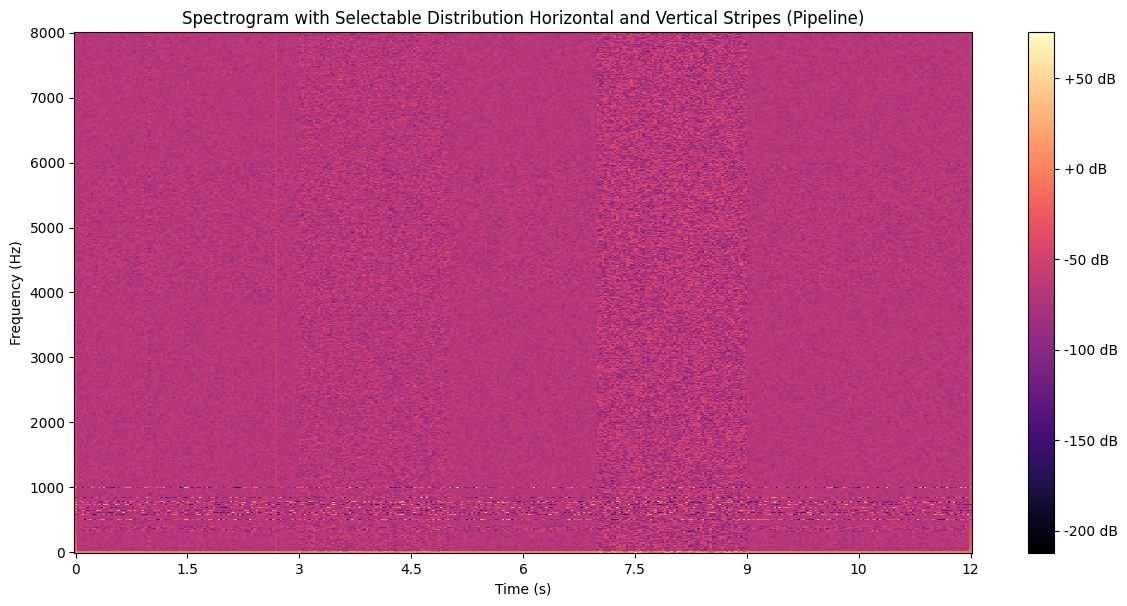

In [6]:
# PEP8 스타일 준수
# 한글 주석
# 기존 SpectrogramModifier, NoisePipeline 구조 유지
# Horizontal/Vertical Stripe 및 주파수/시간 구간별 distribution 기반 dB 패턴을 Shape로 통합
# 외부 설정파일 없이 코드 내에서 유연하게 구성
# distribution 적용을 두 번째 예시처럼 변경

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from abc import ABC, abstractmethod


class SpectrogramModifier:
    def __init__(self, sample_rate=16000, n_fft=1024, hop_length=512,
                 noise_strength=0.1, noise_type='gaussian', noise_params=None):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.noise_strength = noise_strength
        self.noise_type = noise_type
        self.noise_params = noise_params if noise_params else {}
        self.signal = None
        self.signal_with_noise = None
        self.S_db = None

    def _generate_gaussian_noise(self, length, params):
        mean = params.get('mean', 0.0)
        std = params.get('std', 1.0)
        return np.random.normal(mean, std, length)

    def _generate_uniform_noise(self, length, params):
        low = params.get('low', -1.0)
        high = params.get('high', 1.0)
        return np.random.uniform(low, high, length)

    def _generate_perlin_noise(self, length, params):
        # Perlin 노이즈 (간단화)
        def fade(t):
            return 6 * t**5 - 15 * t**4 + 10 * t**3

        seed = params.get('seed', 42)
        np.random.seed(seed)
        perm = np.arange(256)
        np.random.shuffle(perm)
        perm = np.stack([perm, perm]).flatten()
        scale = params.get('scale', 50.0)
        xs = np.linspace(0, length / scale, length)
        xi = np.floor(xs).astype(int)
        xf = xs - xi
        xi = xi % 256
        left_hash = perm[xi]
        right_hash = perm[xi + 1]
        u = fade(xf)
        left_grad = ((left_hash & 1) * 2 - 1) * xf
        right_grad = ((right_hash & 1) * 2 - 1) * (xf - 1)
        noise = (1 - u) * left_grad + u * right_grad
        noise = noise / np.max(np.abs(noise))
        return noise

    def generate_noise(self, signal):
        length = len(signal)
        nt = self.noise_type
        p = self.noise_params
        if nt == 'gaussian':
            noise = self._generate_gaussian_noise(length, p)
        elif nt == 'uniform':
            noise = self._generate_uniform_noise(length, p)
        elif nt == 'perlin':
            noise = self._generate_perlin_noise(length, p)
        else:
            noise = np.zeros_like(signal)
        return signal + noise * self.noise_strength

    def compute_spectrogram(self, signal):
        self.signal = signal
        self.signal_with_noise = self.generate_noise(signal)
        S = np.abs(librosa.stft(
            self.signal_with_noise, n_fft=self.n_fft, hop_length=self.hop_length, window='hann'))
        self.S_db = librosa.amplitude_to_db(S, ref=np.max)
        return self.S_db

    def _get_freqs(self):
        return np.linspace(0, self.sample_rate / 2, self.S_db.shape[0])

    def _get_times(self):
        return librosa.frames_to_time(np.arange(self.S_db.shape[1]),
                                      sr=self.sample_rate,
                                      hop_length=self.hop_length)

    def apply_dB_mask(self, dB_mask):
        self.S_db += dB_mask

    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram'):
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        fig, ax = plt.subplots(figsize=(12, 6))
        img = librosa.display.specshow(
            self.S_db,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap=colormap
        )
        if show_labels:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(title)
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0.5)
        return fig, ax


class Distribution(ABC):
    @abstractmethod
    def sample(self, shape):
        pass


class NormalDistribution(Distribution):
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def sample(self, shape):
        return np.random.normal(self.mean, self.stddev, shape)


class UniformDistribution(Distribution):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def sample(self, shape):
        return np.random.uniform(self.min_val, self.max_val, shape)


class NoneDistribution(Distribution):
    def sample(self, shape):
        return np.zeros(shape)


class DistributionEngine:
    def create(self, dist_type, **params):
        dist_type = dist_type.lower()
        if dist_type == "normal":
            return NormalDistribution(params.get('mean', 0), params.get('stddev', 1))
        elif dist_type == "uniform":
            return UniformDistribution(params.get('min', -1), params.get('max', 1))
        else:
            return NoneDistribution()


class DBShape(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod):
        pass


class BaseShape(DBShape):
    def __init__(self, distribution_engine, distribution_type='none', distribution_params=None):
        self.distribution_engine = distribution_engine
        self.distribution_type = distribution_type
        self.distribution_params = distribution_params if distribution_params else {}

    def _sample_distribution(self, shape):
        dist_obj = self.distribution_engine.create(self.distribution_type, **self.distribution_params)
        return dist_obj.sample(shape)

    @abstractmethod
    def generate_shape_mask(self, spectro_shape, spectro_mod):
        pass

    def create_mask(self, spectro_shape, spectro_mod):
        shape_mask = self.generate_shape_mask(spectro_shape, spectro_mod)
        if self.distribution_type != 'none':
            dist_values = self._sample_distribution(spectro_shape)
            return shape_mask * dist_values
        else:
            return shape_mask


# 주파수 축 상 특정 주파수 지점에 stripe
class HorizontalStripeDBShape(BaseShape):
    def __init__(self, distribution_engine, freq, strength_dB,
                 distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.freq = freq
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_idx = np.argmin(np.abs(freqs - self.freq))
        mask[freq_idx, :] += self.strength_dB
        return mask


# 주파수 구간에 대해 distribution 기반으로 dB를 변형
class HorizontalRangeDistributionDBShape(BaseShape):
    def __init__(self, distribution_engine, freq_min, freq_max, strength_dB,
                 distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        if len(freq_indices) == 0:
            return mask
        for fi in freq_indices:
            mask[fi, :] += self.strength_dB
        return mask


class RandomHorizontalStripesDBShape(BaseShape):
    def __init__(self, distribution_engine, freq_min, freq_max, strength_dB, n, mode='random',
                 distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.strength_dB = strength_dB
        self.n = n
        self.mode = mode

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        available_freqs = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        if len(available_freqs) == 0:
            return mask
        if self.mode == 'linear':
            selected_indices = np.linspace(available_freqs.min(), available_freqs.max(),
                                           num=self.n, dtype=int)
            selected_indices = selected_indices[selected_indices < len(freqs)]
        else:
            n_sel = min(self.n, len(available_freqs))
            selected_indices = np.random.choice(available_freqs, size=n_sel, replace=False)
        for fi in selected_indices:
            mask[fi, :] += self.strength_dB
        return mask


class VerticalStripeDBShape(BaseShape):
    def __init__(self, distribution_engine, time, strength_dB,
                 distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.time = time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        time_idx = np.argmin(np.abs(times - self.time))
        mask[:, time_idx] += self.strength_dB
        return mask


class VerticalRangeDistributionDBShape(BaseShape):
    def __init__(self, distribution_engine, time_min, time_max, strength_dB,
                 distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]
        if len(time_indices) == 0:
            return mask
        for ti in time_indices:
            mask[:, ti] += self.strength_dB
        return mask


class ShapeFactory:
    def __init__(self, distribution_engine):
        self.distribution_engine = distribution_engine

    def create(self, shape_name, **kwargs):
        if shape_name == "horizontal_stripe_db":
            return HorizontalStripeDBShape(
                distribution_engine=self.distribution_engine,
                freq=kwargs['freq'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "horizontal_range_dist_db":
            return HorizontalRangeDistributionDBShape(
                distribution_engine=self.distribution_engine,
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "random_horizontal_stripes_db":
            return RandomHorizontalStripesDBShape(
                distribution_engine=self.distribution_engine,
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                strength_dB=kwargs['strength_dB'],
                n=kwargs['n'],
                mode=kwargs.get('mode', 'random'),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "vertical_stripe_db":
            return VerticalStripeDBShape(
                distribution_engine=self.distribution_engine,
                time=kwargs['time'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "vertical_range_dist_db":
            return VerticalRangeDistributionDBShape(
                distribution_engine=self.distribution_engine,
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        else:
            return None


class Pattern(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        pass


class PatternFactory:
    def create(self, pattern_name, params):
        return None


class NoisePipeline:
    def __init__(self, spectro_mod):
        self.spectro_mod = spectro_mod
        self.distribution_engine = DistributionEngine()
        self.shape_factory = ShapeFactory(self.distribution_engine)
        self.pattern_factory = PatternFactory()
        self.shapes = []
        self.patterns = []

    def add_shape(self, shape):
        if shape is not None:
            self.shapes.append(shape)
        return self

    def add_pattern(self, pattern):
        if pattern is not None:
            self.patterns.append(pattern)
        return self

    def generate(self, signal):
        spec = self.spectro_mod.compute_spectrogram(signal)
        total_mask = np.zeros_like(spec)
        for shape in self.shapes:
            shape_mask = shape.create_mask(spec.shape, self.spectro_mod)
            total_mask += shape_mask
        for pattern in self.patterns:
            pattern_mask = pattern.create_mask(spec.shape, self.spectro_mod,
                                               self.shape_factory,
                                               self.distribution_engine)
            total_mask += pattern_mask
        self.spectro_mod.apply_dB_mask(total_mask)
        return self.spectro_mod.S_db


# 예시: 2번째 그림과 유사한 결과를 위해 코드 상에서 distribution을 활용
sample_rate = 16000
duration = 12
n_samples = sample_rate * duration
np.random.seed(42)
signal = np.random.normal(-80, 1, n_samples)

spectro_mod = SpectrogramModifier(
    sample_rate=sample_rate,
    n_fft=1024,
    hop_length=512,
    noise_strength=0,
    noise_type='perlin',
    noise_params={'seed': 42, 'scale': 5.0}
)

pipeline = NoisePipeline(spectro_mod)

stripe_freqs = [
    {'shape_name': 'horizontal_stripe_db', 'freq': 500, 'strength_dB': 5,
     'distribution_type': 'none'},
    {'shape_name': 'horizontal_stripe_db', 'freq': 1000, 'strength_dB': 2,
     'distribution_type': 'none'},
    {'shape_name': 'horizontal_stripe_db', 'freq': 2000, 'strength_dB': -5,
     'distribution_type': 'none'}
]

stripe_freq_ranges = [
    {'shape_name': 'horizontal_range_dist_db',
     'freq_min': 300, 'freq_max': 400, 'strength_dB': 30,
     'distribution_type': 'normal', 'distribution_params': {'mean':0, 'stddev':0.5}},
    {'shape_name': 'horizontal_range_dist_db',
     'freq_min': 4000, 'freq_max': 6000, 'strength_dB': -10,
     'distribution_type': 'uniform', 'distribution_params': {'min':-1, 'max':1}}
]

stripe_random_freq_ranges = [
    {'shape_name': 'random_horizontal_stripes_db',
     'freq_min': 500, 'freq_max': 1000, 'strength_dB': 40, 'n': 10, 'mode': 'random',
     'distribution_type': 'normal', 'distribution_params': {'mean':0, 'stddev':1}},
    {'shape_name': 'random_horizontal_stripes_db',
     'freq_min': 2000, 'freq_max': 3000, 'strength_dB': -20, 'n': 10, 'mode': 'random',
     'distribution_type': 'uniform', 'distribution_params': {'min':-0.5, 'max':0.5}}
]

stripe_times = [
    {'shape_name': 'vertical_stripe_db', 'time': 1, 'strength_dB': 5,
     'distribution_type': 'normal', 'distribution_params': {'mean':0, 'stddev':2}},
    {'shape_name': 'vertical_stripe_db', 'time': 2.7, 'strength_dB': 10,
     'distribution_type': 'none'},
    {'shape_name': 'vertical_stripe_db', 'time': 1.5, 'strength_dB': 15,
     'distribution_type': 'uniform', 'distribution_params': {'min':-1, 'max':1}}
]

stripe_time_ranges = [
    {'shape_name': 'vertical_range_dist_db',
     'time_min': 3, 'time_max': 5, 'strength_dB': 20,
     'distribution_type': 'normal', 'distribution_params': {'mean':0, 'stddev':0.5}},
    {'shape_name': 'vertical_range_dist_db',
     'time_min': 7, 'time_max': 9, 'strength_dB': -15,
     'distribution_type': 'uniform', 'distribution_params': {'min':-2, 'max':2}}
]

def add_shapes(pipeline, shapes_config):
    for s in shapes_config:
        shape_name = s['shape_name']
        params = {k: v for k, v in s.items() if k != 'shape_name'}
        shape_obj = pipeline.shape_factory.create(shape_name, **params)
        pipeline.add_shape(shape_obj)

add_shapes(pipeline, stripe_freqs)
add_shapes(pipeline, stripe_freq_ranges)
add_shapes(pipeline, stripe_random_freq_ranges)
add_shapes(pipeline, stripe_times)
add_shapes(pipeline, stripe_time_ranges)

result_spectrogram = pipeline.generate(signal)

fig, ax = spectro_mod.plot_spectrogram(
    show_labels=True,
    title='Spectrogram with Selectable Distribution Horizontal and Vertical Stripes (Pipeline)'
)
plt.show()
